# Cowsay

In [1]:
import random
import time
from typing import Tuple

import cowsay

from burr.core import Action, Application, ApplicationBuilder, State, default, expr
from burr.core.action import action
from burr.lifecycle import PostRunStepHook

In [2]:
# create some hooks!
class PrintWhatTheCowSaid(PostRunStepHook):
    def post_run_step(self, *, state: "State", action: "Action", **future_kwargs):
        if action.name != "cow_should_say" and state["cow_said"] is not None:
            print(state["cow_said"])


class CowCantSpeakFast(PostRunStepHook):
    def __init__(self, sleep_time: float):
        super(PostRunStepHook, self).__init__()
        self.sleep_time = sleep_time

    def post_run_step(self, *, state: "State", action: "Action", **future_kwargs):
        if action.name != "cow_should_say":  # no need to print if we're not saying anything
            time.sleep(self.sleep_time)

In [7]:
# instantiate actions
@action(reads=[], writes=["cow_said"])
def cow_said(state: State, say_what: list[str]) -> Tuple[dict, State]:
    said = random.choice(say_what) if say_what is not None else None
    result = {"cow_said": cowsay.get_output_string("cow", said) if say_what is not None else None}
    return result, state.update(**result)


@action(reads=[], writes=["cow_should_speak"])
def cow_should_speak(state: State) -> Tuple[dict, State]:
    result = {"cow_should_speak": random.randint(0, 3) == 0}
    return result, state.update(**result)


In [8]:
# build application
hooks = [
    PrintWhatTheCowSaid(),
    CowCantSpeakFast(sleep_time=2.0),
]
        
app = (ApplicationBuilder()
    .with_state(cow_said=None)
    .with_actions(
        say_nothing=cow_said.bind(say_what=None),
        say_hello=cow_said.bind(
            say_what=["Hello world!", "What's up?", "Are you Aaron Burr, sir?"]
        ),
        cow_should_speak=cow_should_speak,
    )
    .with_transitions(
        ("cow_should_speak", "say_hello", expr("cow_should_speak")),
        ("say_hello", "cow_should_speak", default),
        ("cow_should_speak", "say_nothing", expr("not cow_should_speak")),
        ("say_nothing", "cow_should_speak", default),
    )
    .with_entrypoint("cow_should_speak")
    .with_hooks(*hooks)
    .build()
)

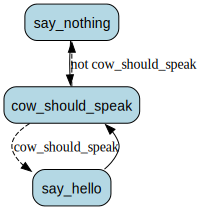

In [9]:
app.visualize(include_conditions=True)

In [10]:
# run things!
for i in range(0, 4):
    # step through 4 times
    a_obj, result, state = app.step()

In [11]:
# Run some more
for i in range(0, 4):
    # step through 4 times
    a_obj, result, state = app.step()

  __________
| What's up? |
          \
           \
             ^__^
             (oo)\_______
             (__)\       )\/\
                 ||----w |
                 ||     ||
  __________
| What's up? |
          \
           \
             ^__^
             (oo)\_______
             (__)\       )\/\
                 ||----w |
                 ||     ||
